From previous notebook, we are clear about all the features to use. In this notebook, I will continue using those features to tune the hyperparamters of RandomForestClassifier.

In [27]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
file_path = '../data/clickdata.csv'
df = pd.read_csv(file_path)

In [3]:
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Browser Webview','Browser')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Robot Mobile','Robot')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Special','Other')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Mobile App','Other')
df['ua_agent_class'] = df['ua_agent_class'].str.replace('Cloud Application','Other')

In [4]:
# Convert epoch_ms to datetime
df['datetime'] = pd.to_datetime(df['epoch_ms'], unit='ms')
df = df.drop(columns=['epoch_ms'])

# Sort by session_id and datetime
df.sort_values(by=['session_id', 'datetime'], inplace=True)

# Calculate time differences between consecutive requests in the same session
df['time_diff'] = df.groupby('session_id')['datetime'].diff().dt.total_seconds().fillna(0)

In [5]:

# Custom function to calculate cumulative unique counts of non-null values
def cumulative_nunique(series):
    # return series.expanding().apply(lambda x: x.nunique(), raw=False)
    seen = set()
    unique_counts = []
    for item in series:
        if pd.notna(item):  # Only add non-null items to the set
            seen.add(item)
        unique_counts.append(len(seen))
    return unique_counts

# Custom function to calculate cumulative counts of non-null values
def cumulative_num_non_null(series):
    non_null_counts = series.notna().cumsum()
    return non_null_counts

# Session-level cumulative feature columns
df['cumulative_session_duration'] = df.groupby('session_id')['time_diff'].cumsum()
# df['cumulative_num_unique_visitor_recognition_type'] = df.groupby('session_id')['visitor_recognition_type'].transform(cumulative_nunique)
df['cumulative_num_requests'] = df.groupby('session_id').cumcount() + 1
# df['cumulative_num_unique_pages_visited'] = df.groupby('session_id')['url_without_parameters'].transform(cumulative_nunique)
df['cumulative_avg_time_between_requests'] = df['cumulative_session_duration'] / (df['cumulative_num_requests'] - 1).replace(0, 1)
df['cumulative_count_referer'] = df.groupby('session_id')['referrer_without_parameters'].transform(cumulative_num_non_null)
df['cumulative_num_unique_referer'] = df.groupby('session_id')['referrer_without_parameters'].transform(cumulative_nunique)

In [6]:
# Define a function to split the URL by '/'
def split_url(url):
    # Remove the domain part if it exists
    if 'https://www.bol.com/nl/' in url:
        url = url.replace('https://www.bol.com/nl/', '')
    
    # Split the URL and filter out empty strings
    return [part for part in url.split('/') if part] # The condition if part ensures that only non-empty strings are included in the resulting list.

# Apply the function to the 'url_without_parameters' column to create the 'url_split' column
df['url_split'] = df['url_without_parameters'].apply(split_url)

# # Join the lists of URL segments into strings for reporting purpose
# df['url_string'] = df['url_split'].apply(lambda x: ' '.join(x))

In [7]:
# Function to extract URL features
def extract_url_features(url):
    features = {}
    features['url_length'] = len(url)
    features['url_depth'] = url.count('/')
    return features

# Apply feature extraction
df_features = df['url_without_parameters'].apply(extract_url_features).apply(pd.Series)

# Combine features with original DataFrame
df = pd.concat([df, df_features], axis=1)

In [8]:
from collections import Counter

# Function to get the most frequent k terms
def get_top_k_terms(df, column, k):
    # Flatten the list of lists
    all_terms = [term for sublist in df[column] for term in sublist]
    
    # Count the frequency of each term
    term_counts = Counter(all_terms)
    
    # Get the most common k terms
    top_k_terms = [term for term, _ in term_counts.most_common(k)]
    
    return top_k_terms

# Function to create one-hot encoded features for top k terms
def create_one_hot_url_term_features(df, column, top_k_terms):
    # Initialize an empty DataFrame
    one_hot_df = pd.DataFrame(index=df.index)
    
    # Iterate over the top k terms and create one-hot encoded columns
    for term in top_k_terms:
        one_hot_df[f'contains_{term}'] = df[column].apply(lambda x: 1 if term in x else 0)
    
    return one_hot_df

In [9]:
k = 25 
top_k_terms = get_top_k_terms(df, 'url_split', k)
one_hot_df = create_one_hot_url_term_features(df, 'url_split', top_k_terms)
df = pd.concat([df, one_hot_df], axis=1)

In [10]:
# Frequency encoding for 'country_by_ip_address'
frequency_country = df['country_by_ip_address'].value_counts()
df['country_frequency_encoded'] = df['country_by_ip_address'].map(frequency_country)

# Frequency encoding for 'region_by_ip_address'
frequency_region = df['region_by_ip_address'].value_counts()
df['region_frequency_encoded'] = df['region_by_ip_address'].map(frequency_region)

# One-hot encoding for 'visitor_recognition_type'
visitor_recognition_one_hot = pd.get_dummies(df['visitor_recognition_type'], drop_first=True)
df = pd.concat([df, visitor_recognition_one_hot], axis=1)

In [11]:
df

,session_id,country_by_ip_address,region_by_ip_address,url_without_parameters,referrer_without_parameters,visitor_recognition_type,ua_agent_class,datetime,time_diff,cumulative_session_duration,...,contains_boeken,contains_paid.html,contains_elektronica,contains_t,contains_b,contains_iets,country_frequency_encoded,region_frequency_encoded,LOGGEDIN,RECOGNIZED
27305,000339eb8412724e0ecd55e695fd5ea1,US,CA,https://www.bol.com/nl/l/juniwer-design-baby-p...,NaN,ANONYMOUS,Robot,2018-03-05 20:19:34.719,0.0,0.0,...,0,0,0,0,0,0,22780.0,20662.0,False,False
27421,00070b81850bd8cf15019f8aa469820c,US,CA,https://www.bol.com/nl/p/modern-questions-of-c...,NaN,ANONYMOUS,Robot,2018-03-05 20:20:41.010,0.0,0.0,...,0,0,0,0,0,0,22780.0,20662.0,False,False
30585,0007273f5ce02adbfbc3058f9e801cc5,US,CA,https://www.bol.com/nl/c/gabrielli-players/256...,NaN,ANONYMOUS,Robot,2018-03-05 20:59:56.066,0.0,0.0,...,0,0,0,0,0,0,22780.0,20662.0,False,False
59710,0007d22c96b6168fd41b7a5360edee75,FR,NaN,https://www.bol.com/nl/p/asus-versasleeve-7i-b...,https://www.bol.com/nl/p/asus-versasleeve-7i-b...,ANONYMOUS,Browser,2018-03-05 21:58:40.328,0.0,0.0,...,0,0,0,0,0,0,348.0,NaN,False,False
50929,000a3e043e0b4d9832c4ea10710502fd,NL,NaN,https://www.bol.com/nl/s/ajax/index.html,https://www.bol.com/nl/s/elektronica/zoekresul...,RECOGNIZED,Browser,2018-03-05 21:50:42.158,0.0,0.0,...,0,0,0,0,0,0,25673.0,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36050,fff6621ab803217e98f99f7328e46a40,NL,ZE,https://www.bol.com/nl/p/vidaxl-binnenfontein-...,NaN,ANONYMOUS,Browser,2018-03-05 20:20:33.805,0.0,0.0,...,0,0,0,0,0,0,25673.0,356.0,False,False
57377,fff7b8c890847fff585e61573c3667b5,US,CA,https://www.bol.com/nl/l/engelstalige-outdoor-...,NaN,ANONYMOUS,Robot,2018-03-05 21:14:16.649,0.0,0.0,...,0,0,0,0,0,0,22780.0,20662.0,False,False
49013,fffc13529d0f34dff188b214477e3327,US,CA,https://www.bol.com/nl/p/marcato-atlas-150-wel...,NaN,ANONYMOUS,Robot,2018-03-05 21:15:09.957,0.0,0.0,...,0,0,0,0,0,0,22780.0,20662.0,False,False
1977,fffc1c7043c575997dec89551b295b67,US,CA,https://www.bol.com/nl/l/agenda-s-2018/N/25305...,NaN,ANONYMOUS,Robot,2018-03-05 20:22:00.034,0.0,0.0,...,0,0,0,0,0,0,22780.0,20662.0,False,False


In [12]:
feature_columns = df.select_dtypes(include=['float64', 'int64', 'bool']).columns.tolist()

# Grid Search Cross Validation for Hyperparameter Tuning

RandomForestClassifier Documentation: [link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Key hyperparameters of interest:

1. `n_estimators`: int, default=100
- What it does: The number of trees in the forest.
- Why tune it: More trees generally improve performance, but also increase computational cost. 

2. `max_depth`: int, default=None
- What it does: The maximum depth of the trees. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- Why tune it: Controls how complex the trees can be. Shallower trees prevent overfitting, deeper trees can capture more complex patterns.

3. `min_samples_split`: int or float, default=2
- What it does: The minimum number of samples required to split an internal node.
- Why tune it: Higher values prevent the model from learning overly specific patterns (overfitting).

4. `min_samples_leaf`: int or float, default=1
- What it does: The minimum number of samples required to be at a leaf node.
- Why tune it: Controls the granularity of the model. Higher values can smooth the model, reducing overfitting.

5. `max_features`: {“sqrt”, “log2”, None}, int or float, default=”sqrt”
- What it does: The number of features to consider when looking for the best split.
- Why tune it: Lower values reduce variance but can increase bias.

In [13]:
from sklearn.model_selection import BaseCrossValidator

# Define customized cross-validator to fulfill 1) session-based 2) stratified splitting 
class SessionBasedStratifiedKFold(BaseCrossValidator):
    def __init__(self, df, n_splits=5):
        self.df = df
        self.n_splits = n_splits

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        session_class = self.df.groupby('session_id')['ua_agent_class'].first().reset_index()
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        
        for train_idx, val_idx in skf.split(session_class['session_id'], session_class['ua_agent_class']):
            train_sessions = session_class['session_id'].iloc[train_idx]
            val_sessions = session_class['session_id'].iloc[val_idx]
            
            train_indices = self.df[self.df['session_id'].isin(train_sessions)].index
            val_indices = self.df[self.df['session_id'].isin(val_sessions)].index
            
            yield train_indices, val_indices


In [14]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Initialize the custom cross-validator
cv = SessionBasedStratifiedKFold(df, n_splits=5)

# Initialize GridSearchCV with the custom cross-validator
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Prepare the feature matrix and target vector
X = df[feature_columns]  
y = df['ua_agent_class']

# Fit GridSearchCV
grid_search.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score: ", grid_search.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=

Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Best F1 score:  0.9849598411141706

# Extra: predict on test set

In [15]:
# Train test split: 1) session based 2) stratified split

from sklearn.model_selection import StratifiedShuffleSplit
# Extract unique session IDs and their corresponding ua_agent_class
session_class = df.groupby('session_id')['ua_agent_class'].first().reset_index()

# Initialize StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_idx, test_idx in split.split(session_class['session_id'], session_class['ua_agent_class']):
    train_sessions = session_class['session_id'].iloc[train_idx]
    test_sessions = session_class['session_id'].iloc[test_idx]

# Create training and test sets based on session IDs
train_df = df[df['session_id'].isin(train_sessions)]
test_df = df[df['session_id'].isin(test_sessions)]

# Display the number of sessions in train and test sets
print(f"Number of sessions in training set: {len(train_sessions)}")
print(f"Number of sessions in test set: {len(test_sessions)}")

# Check the distribution of ua_agent_class in both sets
print("Distribution in training set:")
print(train_df['ua_agent_class'].value_counts(normalize=True))

print("Distribution in test set:")
print(test_df['ua_agent_class'].value_counts(normalize=True))

print(f"Train set #rows: {len(train_df)}")
print(f"Test set #rows: {len(test_df)}")
print(f"Train set #rows ratio: {len(train_df)/len(df)}")

Number of sessions in training set: 24652
Number of sessions in test set: 6164
Distribution in training set:
ua_agent_class
Browser    0.622796
Robot      0.354807
Hacker     0.019773
Other      0.002624
Name: proportion, dtype: float64
Distribution in test set:
ua_agent_class
Browser    0.629139
Robot      0.349036
Hacker     0.019354
Other      0.002471
Name: proportion, dtype: float64
Train set #rows: 47640
Test set #rows: 12142
Train set #rows ratio: 0.7968953865712087


In [16]:
my_classifier = RandomForestClassifier(random_state=42, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=100)

In [21]:
# Prepare the feature matrix and target vector
X_train = train_df[feature_columns]  
y_train = train_df['ua_agent_class']
X_test = test_df[feature_columns]
y_test = test_df['ua_agent_class']
# Fit GridSearchCV
my_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, random_state=42)

In [24]:
from sklearn.metrics import f1_score
y_pred = my_classifier.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.983624286321561


In [25]:
# model accuracy score
print("Accuracy (not a good metric, just for info):", my_classifier.score(X_test, y_test)) 

Accuracy (not a good metric, just for info): 0.9856695766760006


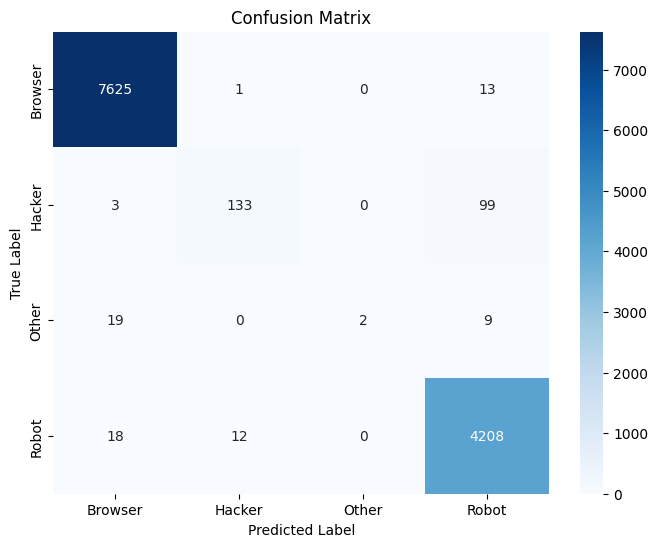

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Step 6: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=my_classifier.classes_, yticklabels=my_classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# predict an individual data record
y_pred = my_classifier.predict([X_test.iloc[42]])[0]
y_real = y_test.iloc[42]
print(y_pred)
print(y_real)

Browser
Browser
